This study benchmarks the JABIRU API's effective dose rate calculations against the CARI-7 code of the United States Federal Aviation Administration. 

The CSV datafile 'EXAMPLE.DAT' contains a list of effective dose rates calculated by CARI-7 for given latitudes, longitudes, and altitudes, on the given date. 

The script overlays the datapoints on a world map (Figure 1), and calculates corresponding effective dose rates using the JABIRU API. The two are plotted alongside each other on Figure 2. 

Further details on the CARI-7 code can be found [here](https://www.faa.gov/data_research/research/med_humanfacs/aeromedical/radiobiology/CARI7/)

In [267]:
import codecs
import json
%matplotlib notebook
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import urllib.request
import yaml 

In [268]:
cari_results = np.loadtxt("./EXAMPLE.DAT", dtype={'names': ('lat', 'long', 'depth', 'step', 'dose rate', 'total dose'), \
                                   'formats': ('f4', 'f4', 'f4', 'i4', 'f4', 'f4')})

In [269]:
longitudes = cari_results['long']
latitudes = cari_results['lat']
#we need to convert longitude as eastings only to eastings and westings
indices = longitudes > 180 
longitudes[indices] = longitudes[indices] - 360 

<IPython.core.display.Javascript object>


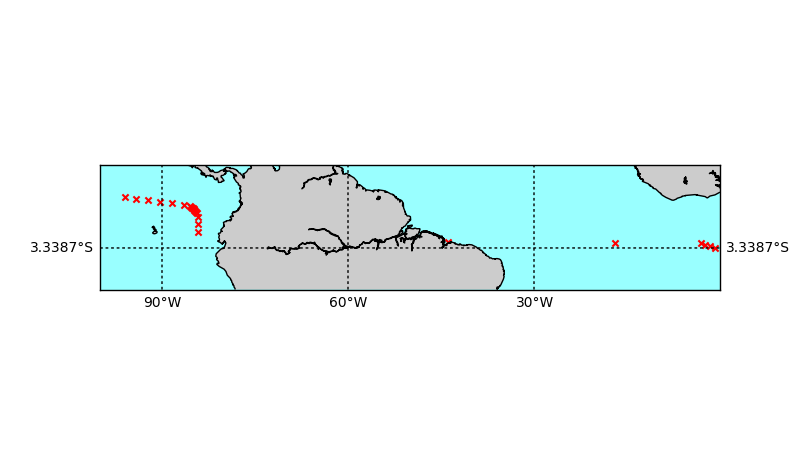

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


In [270]:
fig_map = plt.figure(figsize=(8,4.5))
ax_map = fig_map.add_subplot(111)
m = Basemap(llcrnrlon=-100.,llcrnrlat=-10.,urcrnrlon=0.,urcrnrlat=10.,\
            resolution='l',projection='merc',);
m.drawmapboundary(fill_color='#99ffff');
m.drawcoastlines();
m.fillcontinents();

In [271]:
#draw waypoints on the map
long, lat = m(longitudes,latitudes)
m.scatter(long, lat, 20,marker='x',color='r')

# draw parallels
m.drawparallels(np.arange(np.min(latitudes),np.max(latitudes),20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
plt.show;

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


<IPython.core.display.Javascript object>


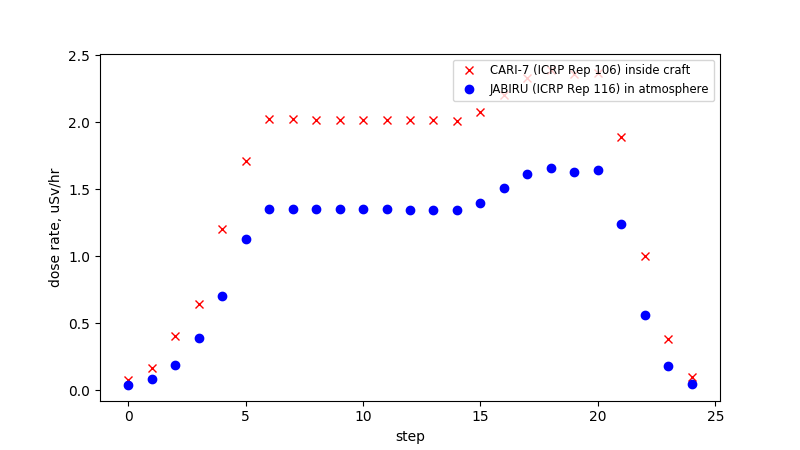

In [272]:
#Initialise the figure
fig_dose = plt.figure(figsize=(8,4.5))

ax_dose = fig_dose.add_subplot(111)
ax_dose.set_xlabel("step")
ax_dose.set_ylabel("dose rate, uSv/hr"); 



In [273]:
reader = codecs.getreader("utf-8")
plt.show()

In [274]:
#construct the target API URL
hostname = "https://api.amentum.space"
hostname = "http://localhost:4000"
api_url = hostname + "/api/calculate_dose_rate?"
#set the date manually in the first instance. 
api_url += "year=2002&"
api_url += "month=1&"
api_url += "day=1&"
api_url += "particle=total&"


In [275]:
#initialise list to store dose rates calculated by JABIRU API
jabiru_dose_rates = []
cari_dose_rates = []

for step in cari_results:
    this_url = api_url
    cari_dose_rates.append(step['dose rate'])
    this_url += "latitude="+np.str(step['lat'])+"&"
    longitude = step['long']
    if longitude > 180 : longitude -= 360 
    this_url += "longitude="+np.str(longitude)+"&"
    this_url += "atmospheric_depth="+np.str(step['depth'])+"&"
    
    #hit the Jabiru API and fetch the effective dose rate
    try:
        response = urllib.request.urlopen(this_url)
    except urllib.error.URLError as e: 
        ResponseData = e.read().decode("utf8", 'ignore')
        print(ResponseData)
    
    json_payload = json.load(reader(response))
    
    dose_rate = json_payload["dose rate"]["value"] # uSv/hr
    
    jabiru_dose_rates.append(dose_rate)
    

In [276]:
ax_dose.plot(cari_dose_rates  #uSv/hr
    , linestyle = "None"
    , marker = "x"
    , color = "r"
    , label = "CARI-7 (ICRP Rep 106) inside craft")

In [277]:
ax_dose.plot(jabiru_dose_rates  #uSv/hr
    , linestyle = "None"
    , marker = "o"
    , color = "b"
    , label = "JABIRU (ICRP Rep 116) in atmosphere")

In [278]:
ax_dose.legend(loc="upper right", fontsize = 'small', numpoints = 1)
